In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
import warnings

warnings.simplefilter(action='ignore')

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from connectomics.atlases import get_dk_rois
from analysis.stats import ols_comparison
from analysis.misc import set_plot_style, add_significance
from analysis.plots import plot_regression
from analysis.surf import assign_val2roi, plot_surface

set_plot_style(dpi=150)
ROIs = get_dk_rois()

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df_dir = os.path.join(data_dir, 'datasets')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
surfplot_dir = os.path.join(plot_dir, 'surfs')
os.makedirs(surfplot_dir, exist_ok=True)

### read BF2 data

amy_prefix = 'fnc'
tau_prefix = 'tnic'
grp_col = 'temporal_meta_tau_asymmetry_group'
covars = ['age', 'gender_baseline_variable']

df_fname = os.path.join(df_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}_mri.csv')
df_bf2 = pd.read_csv(df_fname, low_memory=False, index_col=0)

cols = ['sid', 'mid', grp_col] + covars + [col for col in df_bf2.columns if col.startswith((amy_prefix, tau_prefix, 'aparc_ct_'))]
df_bf2 = df_bf2[cols].copy()
print(f"N (xs) = {df_bf2.shape}")

### read SILA data

sila_dir = os.path.join(data_dir, 'sila')

df = df_bf2.copy()
rois = ['global', 'temporal_meta']
for roi in rois:
    # read SILA results for both hemispheres
    df_ac_left = pd.read_csv(os.path.join(sila_dir, f'sila_out_fnc_{roi}_left.csv'))
    df_ac_right = pd.read_csv(os.path.join(sila_dir, f'sila_out_fnc_{roi}_right.csv'))
    df_ac_left = df_ac_left.rename(columns={'subid': 'sid', 'estdtt0': 'est_ab_yrs'})[['sid', 'age', 'est_ab_yrs']]
    df_ac_right = df_ac_right.rename(columns={'subid': 'sid', 'estdtt0': 'est_ab_yrs'})[['sid', 'age', 'est_ab_yrs']]
    df_ac_left['sid'] = 'BF' + df_ac_left['sid'].astype(str)
    df_ac_right['sid'] = 'BF' + df_ac_right['sid'].astype(str)
    df_ac = pd.merge(df_ac_left, df_ac_right, on=['sid', 'age'], how='inner', suffixes=[f'_{roi}_left', f'_{roi}_right'])
    df_ac[f'est_ab_yrs_diff_{roi}'] = df_ac[f'est_ab_yrs_{roi}_right'] - df_ac[f'est_ab_yrs_{roi}_left']
    df_ac[f'est_ab_yrs_diff_{roi}_abs'] = df_ac[f'est_ab_yrs_diff_{roi}'].abs()
    # merge main df and SILA
    df = df.merge(df_ac, how='left', on=['sid', 'age'])
print(f"N (xs+SILA merged) = {df.shape}")

N (xs) = (452, 1909)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/to8050an/Documents/phd-neurodegeneration-imaging/projects/01_tau_asymmetry/data/sila/sila_out_fnc_global_left.csv'

### figure 4

(a) regression between global Ab LI and tau LI

(c) group comparison in hemispheric difference of Ab onset (SILA)

                            OLS Regression Results                            
Dep. Variable:         tnic_global_LI   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     50.61
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           3.94e-25
Time:                        12:38:22   Log-Likelihood:                -271.36
No. Observations:                 233   AIC:                             550.7
Df Residuals:                     229   BIC:                             564.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

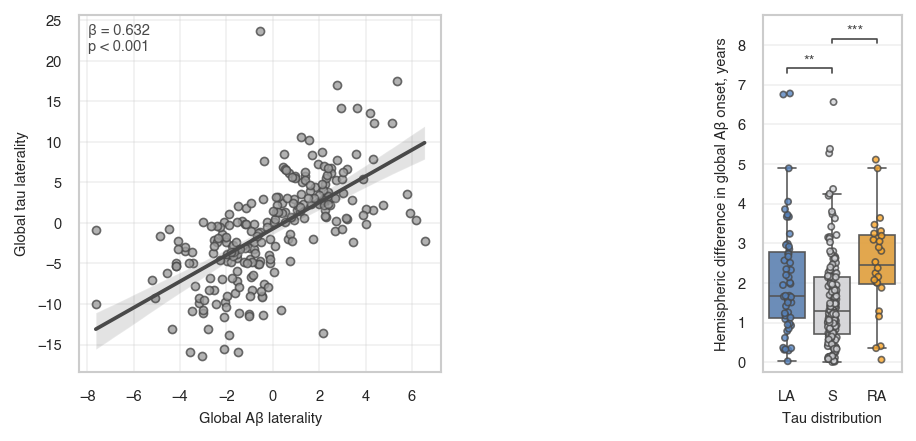

In [24]:
### plot config

grp_colors = {'LA': '#5785C1FF', 'LA-S': '#ff6961', 'S': '#D3D4D8FF', 'RA-S': '#ff6961', 'RA': '#FBA72AFF'}
statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
legend_kwargs = dict(loc='best', title='Tau asymmetry', title_fontsize=7)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
box_kwargs = dict(alpha=0.95, lw=0.8)
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)

fig = plt.figure(figsize=(155.5/25.4, 75/25.4))
gs = fig.add_gridspec(1, 3, width_ratios=[3.25, 1.75, 1.25])
ax_left, ax_middle, ax_right = fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])

# subplot for regression between Ab vs tau lateralities

y = f'{tau_prefix}_global_LI'
ylabel = 'Global tau laterality'

x = f'{amy_prefix}_global_LI'
xlabel = 'Global Aβ laterality'

df_ = df.dropna(subset=[x, y])

_, ax_left, model = plot_regression(df=df_, x=x, y=y, covars=['age', 'gender_baseline_variable'], standardise=True,
                               ax=ax_left, xlabel=xlabel, ylabel=ylabel, 
                               text_kwargs=statann_kwargs, scatter_kwargs=scatter_kwargs)
print(model.summary())

# empty subplot for surface plot

ax_middle.axis('off')

# subplot for SILA

grp_order = ['LA', 'S', 'RA']
grp_comparisons = [('S', 'LA'), ('S', 'RA'), ('LA', 'RA')]
covars = ['age', 'gender_baseline_variable']

y = f'est_ab_yrs_diff_global_abs'
ylabel = 'Hemispheric difference in global Aβ onset, years'

df_ = df.dropna(subset=y)

data = {g: df_.loc[df_[grp_col]==g, y].to_numpy() for g in grp_order}
dfs_covars = {g: df_.loc[df_[grp_col]==g, covars] for g in grp_order}

data_args = dict(ax=ax_right, y=y, x=grp_col, data=df_, order=grp_order, palette=grp_colors)
sns.boxplot(**data_args, showfliers=False)
sns.stripplot(**data_args, **strip_kwargs)
ax_right.set_xlabel('Tau distribution')
ax_right.set_ylabel(ylabel)

for box in ax_right.patches:
    box.set_linewidth(box_kwargs['lw'])
    box.set_alpha(box_kwargs['alpha'])
for line in ax_right.lines:
    line.set_linewidth(box_kwargs['lw'])
    line.set_alpha(box_kwargs['alpha'])

tvals, pvals, pvals_cor, models = ols_comparison(dfs_covars, data, grp_comparisons, covars=covars,
                                                 standardise=True, posthoc='bonferroni')
print(f'\n{ylabel}')
for g in grp_order:
    print(f'{g} median years = {np.median(data[g]).round(3)}')
    # print(f'{g} mean years = {np.mean(data[g]).round(3)}')
print(f'tvals:\n{tvals}')
print(f'pvals:\n{pvals_cor}')
if grp_comparisons is not None and pvals_cor is not None:
    add_significance(ax_right, grp_order, grp_comparisons, pvals_cor, hide_ns=True, **pval_kwargs)
ax_right.set_ylim([-0.25, 8.75])

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'regression_SILA_ab_LI_tau_LI_global.pdf'), format='pdf', dpi=300)
plt.show()

(b) regression between regional Ab LI and tau LI

Context leak detected, msgtracer returned -1


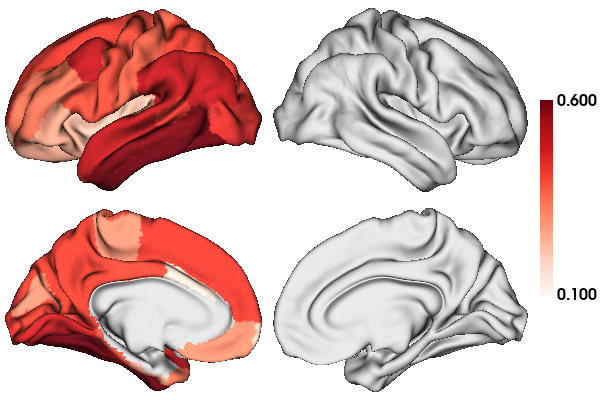

{'L_parsorbitalis': 0.248208366133177,
 'L_inferiorparietal': 0.4958295989531007,
 'L_Amygdala': 0.3842812600059664,
 'L_entorhinal': 0.26424108272862823,
 'L_parstriangularis': 0.2612751386802922,
 'L_insula': 0.20766947550970713,
 'L_parahippocampal': 0.3843621310166213,
 'L_isthmuscingulate': 0.41350300770522713,
 'L_cuneus': 0.29315365202111276,
 'L_lateralorbitofrontal': 0.2484186040497248,
 'L_posteriorcingulate': 0.4009691206178885,
 'L_medialorbitofrontal': 0.29882287926828055,
 'L_inferiortemporal': 0.6330984129862145,
 'L_parsopercularis': 0.39172940540580503,
 'L_postcentral': 0.3607159459399966,
 'L_paracentral': 0.2916915085216253,
 'L_pericalcarine': 0.40671677158397984,
 'L_precuneus': 0.4136696725479641,
 'L_lingual': 0.4685777533045275,
 'L_fusiform': 0.61336720443857,
 'L_precentral': 0.395116207324374,
 'L_caudalanteriorcingulate': 0.1670856860419289,
 'L_temporalpole': 0.33390986980215626,
 'L_supramarginal': 0.49510321689163994,
 'L_transversetemporal': 0.275298148

In [25]:
fnc_li_cols = [col for col in df.columns if ('LI' in col and 'fnc' in col and any(region in col for region in ROIs['global']))]
tnic_li_cols = [col for col in df.columns if ('LI' in col and 'tnic' in col and any(region in col for region in ROIs['global']))]

df_ = df.dropna(subset=fnc_li_cols+tnic_li_cols)

fnc_tnic_b = {}
for region in ROIs['global']:
    # find matching columns for the current region
    fnc_col = next((col for col in fnc_li_cols if region in col), None)
    tnic_col = next((col for col in tnic_li_cols if region in col), None)
    
    try:
        # prepare data and optionally z-score
        df_v = df_[[fnc_col, tnic_col] + ['age', 'gender_baseline_variable']]
        df_v = zscore(df_v)
        
        # OLS regression and extract the parameters for the main predictor
        model = sm.OLS(df_v[tnic_col], sm.add_constant(df_v[[fnc_col] + ['age', 'gender_baseline_variable']])).fit()
        b, pval = model.params[fnc_col], model.pvalues[fnc_col]
    except:
        b, pval = np.nan, np.nan
    fnc_tnic_b[region] = {'b': b, 'pval': pval}

# apply FDR correction
fnc_tnic_b_fdr = fnc_tnic_b.copy()
non_nan_pvals = {region: info['pval'] for region, info in fnc_tnic_b_fdr.items() if not np.isnan(info['pval'])}
_, pvals_fdr, _, _ = multipletests(list(non_nan_pvals.values()), alpha=0.05, method='fdr_bh')

for i, reg in enumerate(non_nan_pvals.keys()):
    fnc_tnic_b_fdr[reg]['pval_fdr'] = pvals_fdr[i]

for reg, info in fnc_tnic_b_fdr.items():
    if 'pval_fdr' not in info:
        fnc_tnic_b_fdr[reg]['pval_fdr'] = np.nan

fnc_tnic_b_fdr = {f"L_{region}": values['b'] for region, values in fnc_tnic_b_fdr.items() if values['pval_fdr'] < 0.05}

# plot surface
export_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=5)
embed_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=1)
fig_args = dict(data=fnc_tnic_b_fdr, atlas='aparc', cmap='Reds', cmap_range=(0.1, 0.6), layout_style='grid')
fig_surf = plot_surface(**fig_args, plot_kwargs=embed_kwargs)
_ = plot_surface(**fig_args, plot_kwargs=export_kwargs, output=os.path.join(surfplot_dir, 'surf_ab_LI_tau_LI_betas.png'))
display(fig_surf)
display(fnc_tnic_b_fdr)

### figure E1 & E2

const_reg=global; reg=early_amyloid; beta=0.5474430633089753


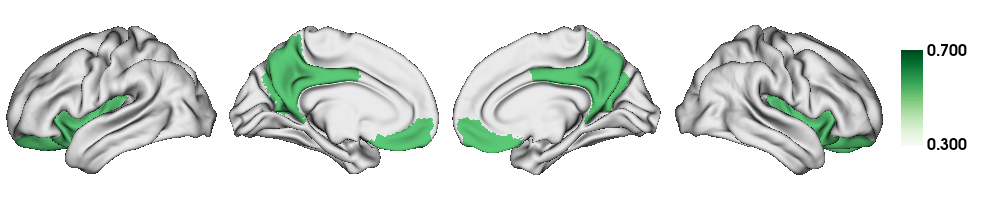

const_reg=global; reg=intermediate_amyloid; beta=0.6343440484489692


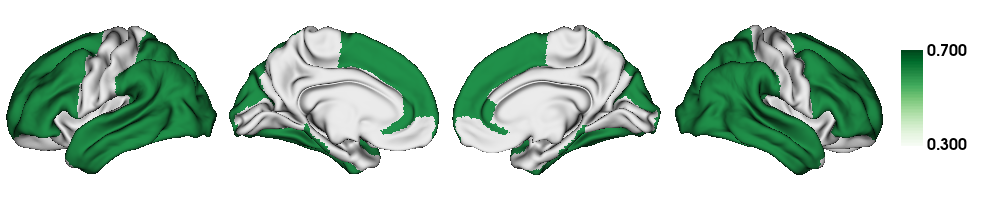

const_reg=global; reg=late_amyloid; beta=0.6089404421890373


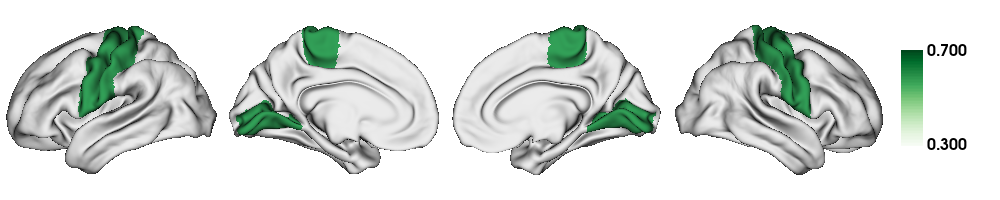

const_reg=global; reg=cho_com_I_II; beta=0.44310015299895067


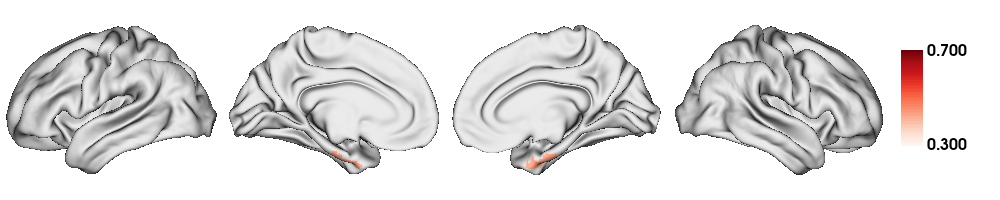

const_reg=global; reg=cho_com_III_IV; beta=0.6541133576824522


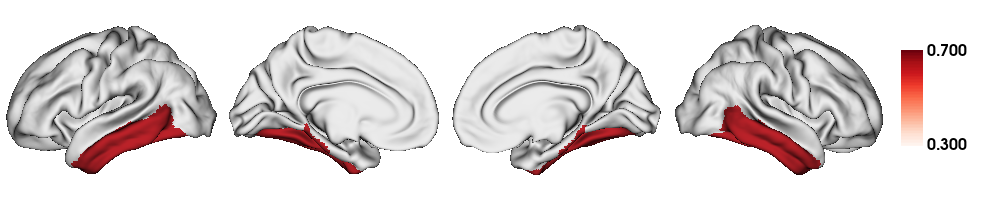

const_reg=global; reg=cho_com_V_VI; beta=0.5935390349087695


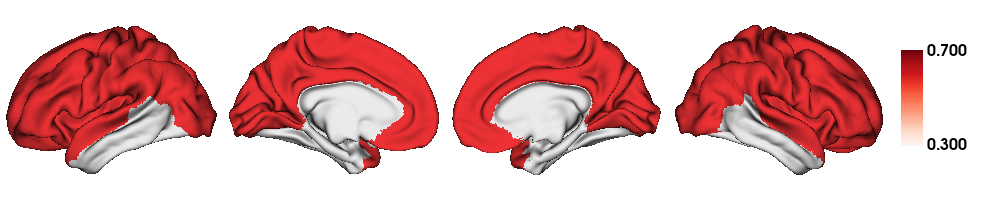

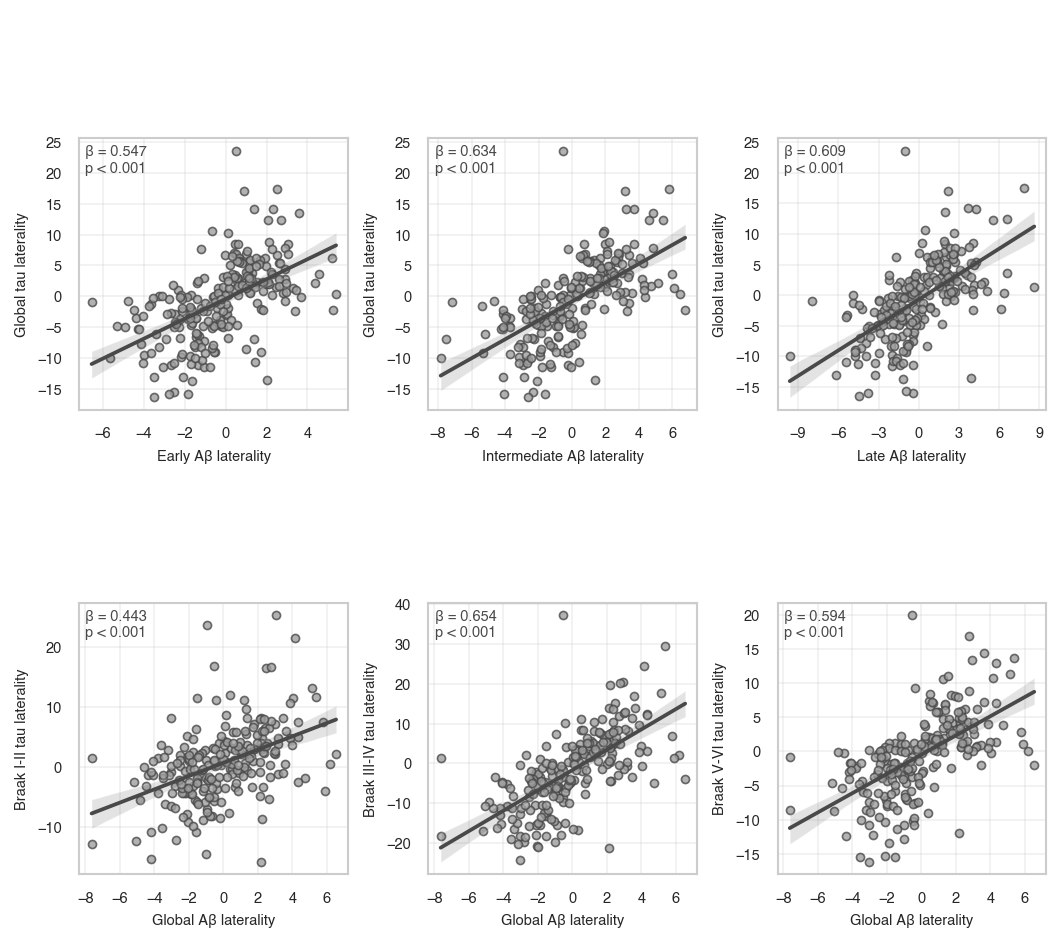

const_reg=temporal_meta; reg=early_amyloid; beta=0.553094092687175


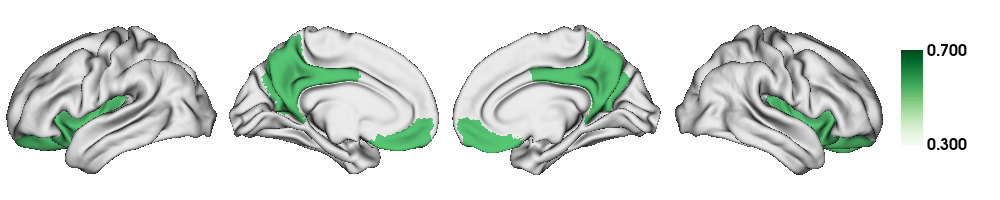

const_reg=temporal_meta; reg=intermediate_amyloid; beta=0.6657335626860592


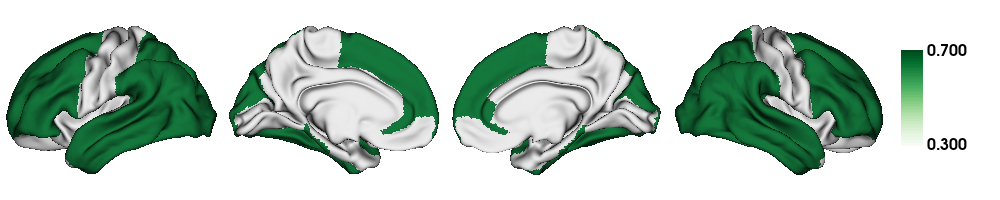

const_reg=temporal_meta; reg=late_amyloid; beta=0.6011078457584527


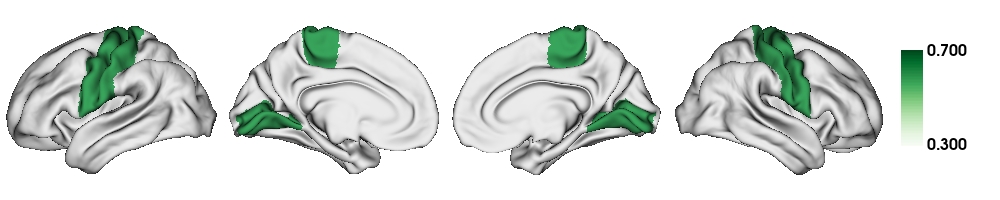

const_reg=temporal_meta; reg=cho_com_I_II; beta=0.46364052894742663


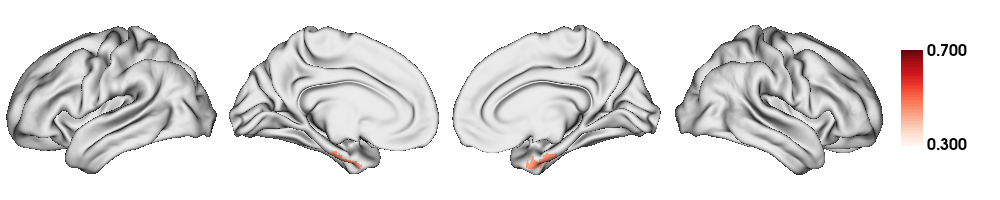

const_reg=temporal_meta; reg=cho_com_III_IV; beta=0.6440815364650486


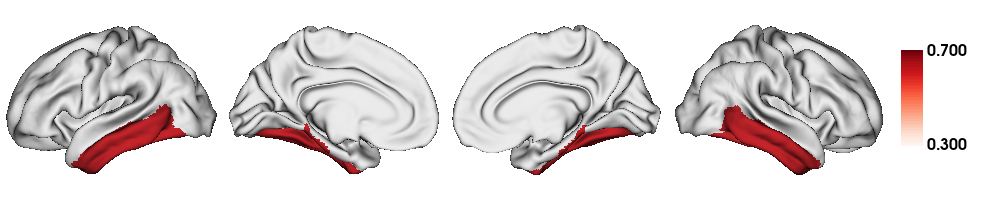

const_reg=temporal_meta; reg=cho_com_V_VI; beta=0.5320644386267931


Context leak detected, msgtracer returned -1


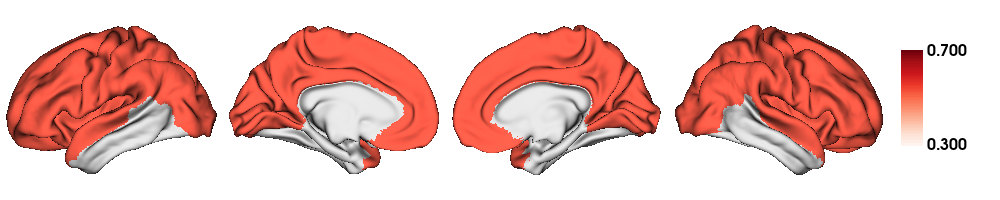

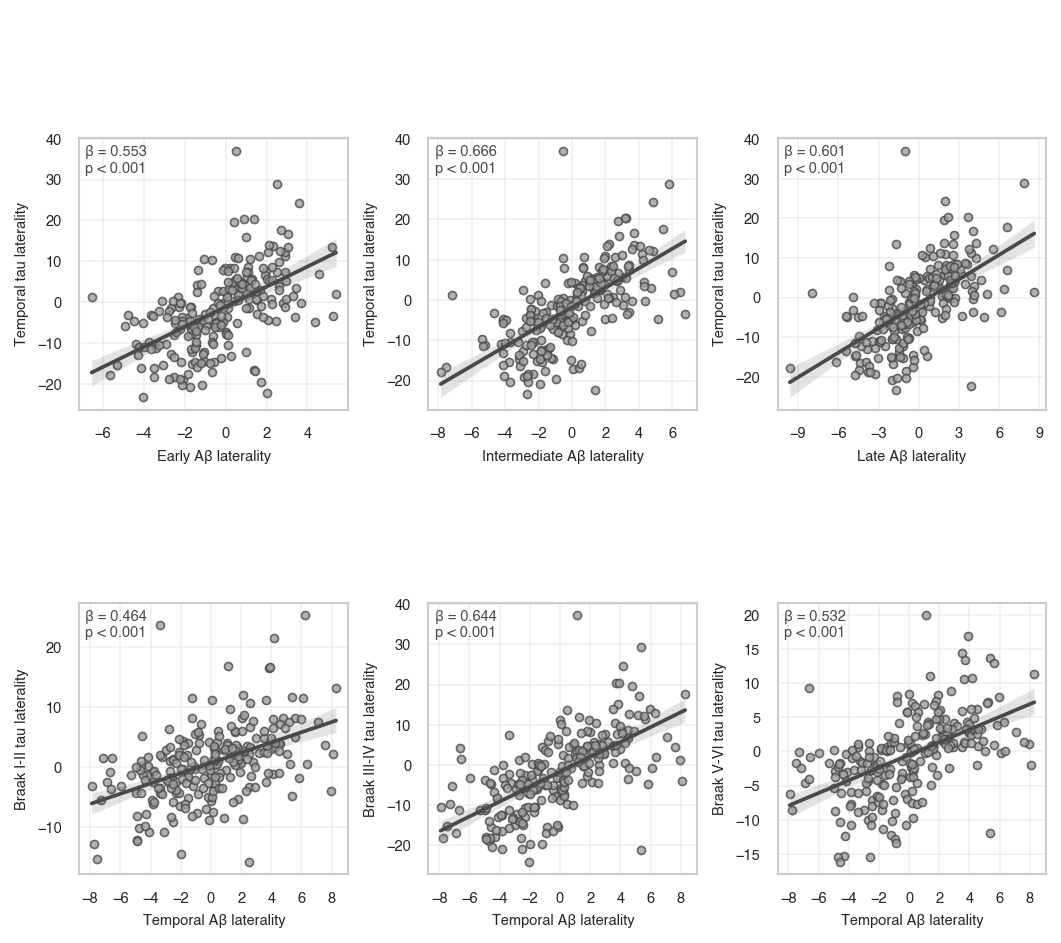

In [26]:
from matplotlib.ticker import MaxNLocator

statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
label_dict = {f'{tau_prefix}_temporal_meta_LI': 'Temporal tau laterality', f'{tau_prefix}_cho_com_I_II_LI': 'Braak I-II tau laterality', 
              f'{tau_prefix}_cho_com_III_IV_LI': 'Braak III-IV tau laterality', f'{tau_prefix}_cho_com_V_VI_LI': 'Braak V-VI tau laterality', 
              f'{amy_prefix}_temporal_meta_LI': 'Temporal Aβ laterality', f'{amy_prefix}_early_amyloid_LI': 'Early Aβ laterality', 
              f'{amy_prefix}_intermediate_amyloid_LI': 'Intermediate Aβ laterality', f'{amy_prefix}_late_amyloid_LI': 'Late Aβ laterality',
              f'{tau_prefix}_global_LI': 'Global tau laterality', f'{amy_prefix}_global_LI': 'Global Aβ laterality'}

for const_reg in ['global_LI', 'temporal_meta_LI']:

    reg_cols = {f'{tau_prefix}_{const_reg}': [f'{amy_prefix}_early_amyloid_LI', f'{amy_prefix}_intermediate_amyloid_LI', f'{amy_prefix}_late_amyloid_LI'],
                f'{amy_prefix}_{const_reg}': [f'{tau_prefix}_cho_com_I_II_LI', f'{tau_prefix}_cho_com_III_IV_LI', f'{tau_prefix}_cho_com_V_VI_LI']}

    df_ = df.dropna(subset=[f'{tau_prefix}_{const_reg}', f'{amy_prefix}_{const_reg}'])

    fig, axs = plt.subplots(4, 3, figsize=(180/25.4, 160/25.4), gridspec_kw={'height_ratios': [0.2, 1, 0.2, 1]})
    for j in range(3):
        axs[0, j].axis('off'), axs[2, j].axis('off')
    for i, (key_col, val_cols) in enumerate(reg_cols.items()):
        for j, val_col in enumerate(val_cols):
            # tau col on y-axis and ab col on x-axis
            if tau_prefix in key_col:
                x_col, y_col = val_col, key_col
            elif amy_prefix in key_col:
                x_col, y_col = key_col, val_col
            
            # plot in rows 1 and 3
            plot_row = 1 if i == 0 else 3
            _, axs[plot_row, j], mdl = plot_regression(df=df_, x=x_col, y=y_col, 
                                                    covars=['age', 'gender_baseline_variable'], 
                                                    standardise=True,
                                                    ax=axs[plot_row, j], 
                                                    xlabel=label_dict[x_col], 
                                                    ylabel=label_dict[y_col],
                                                    text_kwargs=statann_kwargs, 
                                                    scatter_kwargs=scatter_kwargs)
            axs[plot_row, j].xaxis.set_major_locator(MaxNLocator(integer=True))
            
            b = mdl.params[x_col]
            roiname = val_col.split('_', 1)[1][:-3]
            print(f'const_reg={const_reg[:-3]}; reg={roiname}; beta={b}')

            cmap = 'Greens' if plot_row == 1 else 'Reds'
            surf_args = dict(data=assign_val2roi(ROIs[roiname], b), atlas='aparc', cmap=cmap, cmap_range=(0.3, 0.7))
            fig_surf = plot_surface(**surf_args, plot_kwargs=dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.35, transparent_bg=False, scale=1))
            _ = plot_surface(**surf_args, output=os.path.join(surfplot_dir, f'surf_{key_col}_with_{val_col}_beta.png'))
            display(fig_surf)
            

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'regression_ab_LI_tau_LI_ROIs_with_{const_reg}.pdf'), format='pdf', dpi=300)
    plt.show()

### figure S1

lateralities with partial volume correction

N (xs) = (469, 622)


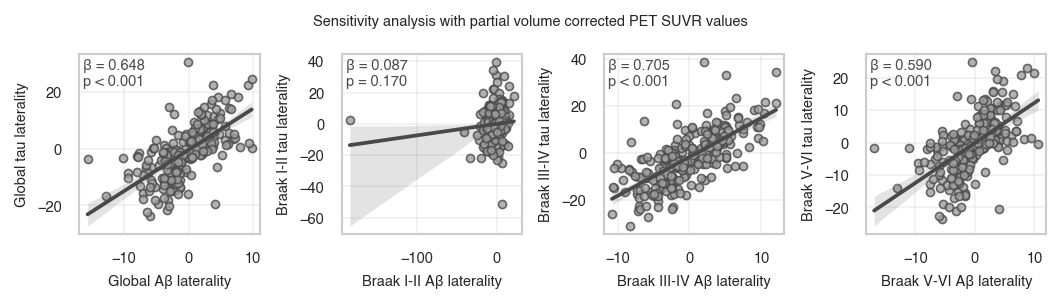

In [42]:
amy_prefix = 'fgc'
tau_prefix = 'tgic'
grp_col = 'temporal_meta_tau_asymmetry_group'
covars = ['age', 'gender_baseline_variable']

base_dir = os.path.join(os.getcwd(), 'data', 'datasets')
df_bf2 = pd.read_csv(os.path.join(base_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}_mri.csv'), low_memory=False, index_col=0)

cols = ['sid', 'mid', grp_col] + covars + [col for col in df_bf2.columns if col.startswith((amy_prefix, tau_prefix, 'aparc_ct_'))]
df_bf2 = df_bf2[cols].copy()
print(f"N (xs) = {df_bf2.shape}")

### plot config

grp_colors = {'LA': '#5785C1FF', 'LA-S': '#ff6961', 'S': '#D3D4D8FF', 'RA-S': '#ff6961', 'RA': '#FBA72AFF'}
statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
legend_kwargs = dict(loc='best', title='Tau asymmetry', title_fontsize=7)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
box_kwargs = dict(alpha=0.95, lw=0.8)
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)

label_dict = {f'{tau_prefix}_temporal_meta_LI': 'Temporal tau laterality', f'{tau_prefix}_cho_com_I_II_LI': 'Braak I-II tau laterality', 
              f'{tau_prefix}_cho_com_III_IV_LI': 'Braak III-IV tau laterality', f'{tau_prefix}_cho_com_V_VI_LI': 'Braak V-VI tau laterality', 
              f'{amy_prefix}_temporal_meta_LI': 'Temporal Aβ laterality', f'{amy_prefix}_cho_com_I_II_LI': 'Braak I-II Aβ laterality', 
              f'{amy_prefix}_cho_com_III_IV_LI': 'Braak III-IV Aβ laterality', f'{amy_prefix}_cho_com_V_VI_LI': 'Braak V-VI Aβ laterality',
              f'{tau_prefix}_global_LI': 'Global tau laterality', f'{amy_prefix}_global_LI': 'Global Aβ laterality'}

fig, axs = plt.subplots(1, 4, figsize=(180/25.4, 50/25.4))

# subplot for regression between Ab vs tau lateralities

for i, roi in enumerate(['global_LI', 'cho_com_I_II_LI', 'cho_com_III_IV_LI', 'cho_com_V_VI_LI']):
    y = f'{tau_prefix}_{roi}'
    x = f'{amy_prefix}_{roi}'

    df_ = df_bf2.dropna(subset=[x, y])
    _, axs[i], model = plot_regression(df=df_, x=x, y=y, covars=['age', 'gender_baseline_variable'], standardise=True,
                                ax=axs[i], xlabel=label_dict[x], ylabel=label_dict[y], 
                                text_kwargs=statann_kwargs, scatter_kwargs=scatter_kwargs)
    # print(model.summary())


plt.suptitle("Sensitivity analysis with partial volume corrected PET SUVR values", fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'sens_partialvolcor_xs_laterality.pdf'), format='pdf', dpi=300)
plt.show()

In [5]:
# _, _, model = plot_regression(df=df_bf2_, x=x, y=y, covars=['age', 'gender_baseline_variable', f'aparc_ct_{y_roi}'], standardise=True)